In [416]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [417]:
# Extract the first frame from the video
cap = cv2.VideoCapture(r"D:\Documents\ComputerVision\Assignment_2\assignment_2_materials\book.mov")  # Replace with your video file path
ret, frame = cap.read()
if ret:
    cv2.imwrite('video_frame.jpg', frame)  # Save the first frame as an image
cap.release()


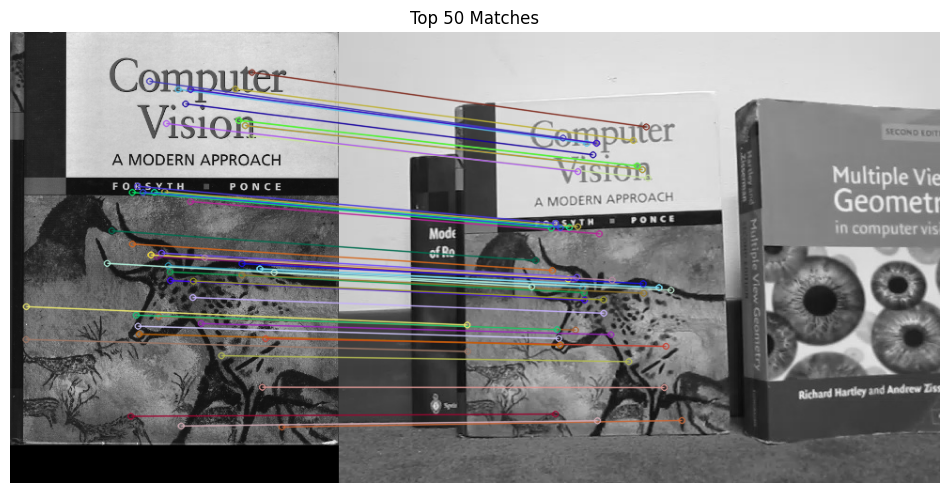

In [418]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Step 1: Load images
book_image = cv2.imread(r"D:\Documents\ComputerVision\Assignment_2\assignment_2_materials\cv_cover.jpg", cv2.IMREAD_GRAYSCALE)  # Replace with the path to your book image
video_frame = cv2.imread('video_frame.jpg', cv2.IMREAD_GRAYSCALE)  # Replace with the first frame of the video

# Step 2: Detect keypoints and compute descriptors using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(book_image, None)
keypoints2, descriptors2 = sift.detectAndCompute(video_frame, None)

# Step 3: Match descriptors using BFMatcher with KNN
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Step 4: Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Step 5: Sort matches by distance and choose top 50
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

# Step 6: Visualize matches
output_image = cv2.drawMatches(
    book_image, keypoints1,
    video_frame, keypoints2,
    good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Step 7: Display the output
plt.figure(figsize=(12, 6))
plt.imshow(output_image)
plt.title("Top 50 Matches")
plt.axis("off")
plt.show()


In [419]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_homography(src_points, dst_points):
    """
    Computes the homography matrix H given at least 4 pairs of corresponding points.

    Parameters:
    src_points (numpy.ndarray): Nx2 array of points from the source image.
    dst_points (numpy.ndarray): Nx2 array of corresponding points from the destination image.

    Returns:
    numpy.ndarray: The computed 3x3 homography matrix H.
    """
    assert src_points.shape[0] >= 4, "At least 4 point correspondences are required."
    assert src_points.shape == dst_points.shape, "Source and destination points must have the same shape."

    n_points = src_points.shape[0]
    A = []

    # Build matrix A for each pair of points
    for i in range(n_points):
        x, y = src_points[i]
        x_prime, y_prime = dst_points[i]

        # Two rows of the matrix for each correspondence
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)

    # Solve the system using Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)  # The solution is the last row of Vt

    # Normalize H to ensure H[2, 2] = 1
    H = H / H[-1, -1]
    return H


In [420]:

def verify_homography(H, src_points, dst_points):
    """
    Verifies the homography by mapping src_points to the destination image
    and comparing with dst_points.

    Parameters:
    H (numpy.ndarray): Homography matrix.
    src_points (numpy.ndarray): Source points (Nx2).
    dst_points (numpy.ndarray): Destination points (Nx2).

    Returns:
    numpy.ndarray: Transformed source points (Nx2).
    """
    # Convert src_points to homogeneous coordinates
    src_points_h = np.hstack((src_points, np.ones((src_points.shape[0], 1))))  # Nx3

    # Transform the points using H
    dst_points_h = (H @ src_points_h.T).T  # Nx3

    # Normalize to get non-homogeneous coordinates
    dst_points_transformed = dst_points_h[:, :2] / dst_points_h[:, 2:]
    return dst_points_transformed


In [421]:

def visualize_homography(src_img, dst_img, src_points, dst_points, transformed_points):
    """
    Visualizes the original points and the transformed points on both images.

    Parameters:
    src_img (numpy.ndarray): Source image.
    dst_img (numpy.ndarray): Destination image.
    src_points (numpy.ndarray): Original points in the source image (Nx2).
    dst_points (numpy.ndarray): Corresponding points in the destination image (Nx2).
    transformed_points (numpy.ndarray): Points transformed using the homography matrix (Nx2).
    """
    plt.figure(figsize=(12, 6))

    # Source image
    plt.subplot(1, 2, 1)
    plt.imshow(src_img, cmap='gray')
    plt.scatter(src_points[:, 0], src_points[:, 1], color='r', label='Source Points')
    plt.title("Source Image")
    plt.legend()

    # Destination image
    plt.subplot(1, 2, 2)
    plt.imshow(dst_img, cmap='gray')
    plt.scatter(dst_points[:, 0], dst_points[:, 1], color='g', label='Destination Points')
    plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='b', marker='x', label='Transformed Points')
    plt.title("Destination Image")
    plt.legend()

    plt.show()




Homography Matrix:
 [[ 7.77238692e-01  4.73475487e-03  1.19080161e+02]
 [-4.92135682e-02  7.81872697e-01  7.70930069e+01]
 [-8.41164017e-05 -6.92129434e-05  1.00000000e+00]]
Transformed Points:
 [[227.09165187 253.54683082]
 [243.57178498 262.41969647]
 [260.73654085 276.78047576]
 [274.00962729 117.5460742 ]
 [365.1780337  413.23576227]
 [258.86512699 271.42813945]
 [208.88529741 242.58088973]
 [248.79911063 263.92324802]
 [263.24001519 117.95854472]
 [322.80578848 146.33256186]
 [322.80578848 146.33256186]
 [274.00962729 117.5460742 ]
 [243.57178498 262.41969647]
 [340.1607158  271.480025  ]
 [276.93095253 214.52815965]
 [233.80925604 325.59678618]
 [244.95914504 207.65018163]
 [317.1153807  142.19138792]
 [347.53552287 333.71258551]
 [235.0074857  332.58243183]
 [328.68209207 155.02040495]
 [238.33699193 112.13770406]
 [340.1607158  271.480025  ]
 [261.14939627 284.44137374]
 [324.05280628 267.44775515]
 [327.14859465 100.24432978]
 [136.85341561 339.96075913]
 [346.07870072 377.554

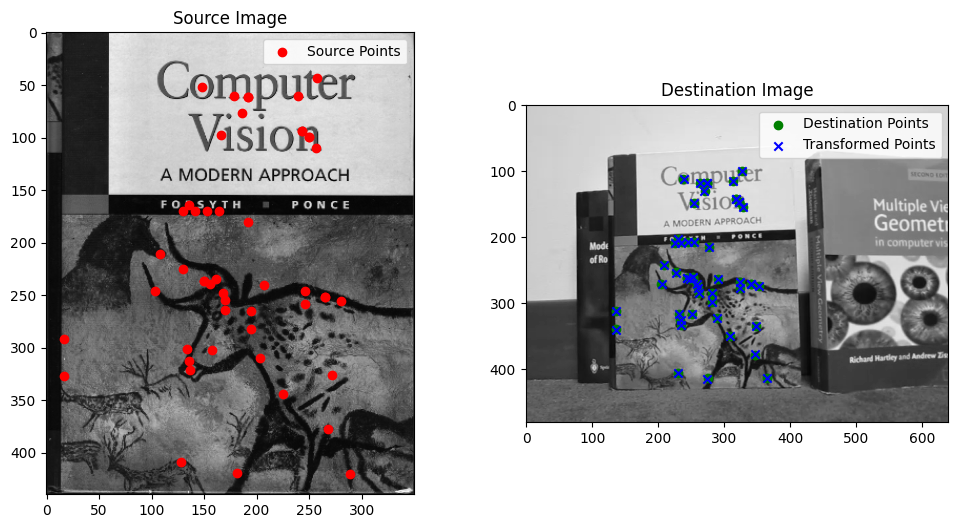

In [422]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Assuming 'good_matches', 'keypoints1', and 'keypoints2' are available from your earlier matching step
def get_points_from_matches(good_matches, keypoints1, keypoints2):
    """
    Extracts corresponding points from the best matches.

    Parameters:
    good_matches (list of cv2.DMatch): Best matches.
    keypoints1 (list of cv2.KeyPoint): Keypoints from the first image.
    keypoints2 (list of cv2.KeyPoint): Keypoints from the second image.

    Returns:
    tuple: Two Nx2 arrays of points (src_points, dst_points).
    """
    src_points = []
    dst_points = []

    for match in good_matches:
        src_idx = match.queryIdx
        dst_idx = match.trainIdx

        src_points.append(keypoints1[src_idx].pt)
        dst_points.append(keypoints2[dst_idx].pt)

    return np.array(src_points), np.array(dst_points)

# Extract the best 50 matches
best_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

# Extract points from the best matches
src_pts, dst_pts = get_points_from_matches(good_matches, keypoints1, keypoints2)

# Compute the homography matrix using the best matches
H = compute_homography(src_pts, dst_pts)
print("Homography Matrix:\n", H)

# Verify the homography
transformed_pts = verify_homography(H, src_pts, dst_pts)
print("Transformed Points:\n", transformed_pts)

# Visualization (assuming you have grayscale images 'book_image' and 'video_frame')
visualize_homography(book_image, video_frame, src_pts, dst_pts, transformed_pts)


Mapped Corners in Video Frame:
 [[119.08016099  77.09300692]
 [402.97766423  61.68428922]
 [418.24770582 429.62435303]
 [124.9692279  434.34438518]]


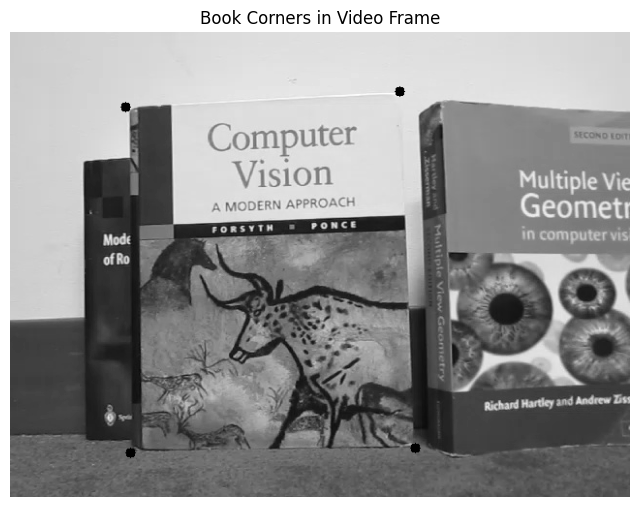

In [423]:
def map_book_corners(H, book_image):
    """
    Maps the four corners of the book image to the video frame using the homography matrix.

    Parameters:
    H (numpy.ndarray): The 3x3 homography matrix.
    book_image (numpy.ndarray): The book image.

    Returns:
    numpy.ndarray: The mapped corner points in the video frame.
    """
    h, w = book_image.shape[:2]  # Get the dimensions of the book image

    # Define the four corners of the book image in (x, y) coordinates
    corners = np.array([
        [0, 0],      # Top-left
        [w, 0],      # Top-right
        [w, h],      # Bottom-right
        [0, h]       # Bottom-left
    ])

    # Convert to homogeneous coordinates (x, y, 1)
    corners_homogeneous = np.hstack((corners, np.ones((4, 1))))  # Shape: (4, 3)

    # Map the corners using the homography matrix
    mapped_corners_homogeneous = (H @ corners_homogeneous.T).T  # Shape: (4, 3)

    # Convert back to Cartesian coordinates
    mapped_corners = mapped_corners_homogeneous[:, :2] / mapped_corners_homogeneous[:, 2:]

    return mapped_corners

# Map the book corners to the video frame
mapped_corners = map_book_corners(H, book_image)
print("Mapped Corners in Video Frame:\n", mapped_corners)

# Visualization of corners on the video frame
def visualize_book_corners(video_frame, mapped_corners):
    """
    Visualizes the mapped corners on the video frame.

    Parameters:
    video_frame (numpy.ndarray): The first frame of the video.
    mapped_corners (numpy.ndarray): The mapped corner points in the video frame.
    """
    frame_with_corners = video_frame.copy()
    for corner in mapped_corners:
        x, y = int(corner[0]), int(corner[1])
        cv2.circle(frame_with_corners, (x, y), 5, (0, 255, 0), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(frame_with_corners, cmap='gray')
    plt.title("Book Corners in Video Frame")
    plt.axis("off")
    plt.show()

# Visualize the mapped corners
visualize_book_corners(video_frame, mapped_corners)


In [424]:
import cv2
import numpy as np

def calculate_book_dimensions(mapped_corners):
    """
    Calculates the width and height of the book in the video frame from the mapped corners.

    Parameters:
    mapped_corners (numpy.ndarray): The four corners of the book in the video frame.

    Returns:
    tuple: (book_width, book_height)
    """
    width = np.linalg.norm(mapped_corners[1] - mapped_corners[0])  # Top-left to top-right
    height = np.linalg.norm(mapped_corners[3] - mapped_corners[0])  # Top-left to bottom-left
    return int(width), int(height)


In [425]:
def crop_ar_frame_to_fit_book(frame, book_width, book_height):
    """
    Crop and resize the AR video frame to match the book's aspect ratio,
    removing black padding from the top and bottom.
    """
    # Detect non-black region in the frame
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, binary_mask = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)  # Binary mask of non-black areas
    y_coords = np.where(np.any(binary_mask, axis=1))[0]  # Rows with non-zero pixels

    if len(y_coords) > 0:
        y_start, y_end = y_coords[0], y_coords[-1]  # First and last non-black row
        frame = frame[y_start:y_end + 1, :]  # Crop top and bottom to content area

    # Proceed with resizing to match the book's aspect ratio
    book_aspect_ratio = book_width / book_height
    frame_height, frame_width = frame.shape[:2]
    frame_aspect_ratio = frame_width / frame_height

    if frame_aspect_ratio > book_aspect_ratio:
        # Wider AR frame than book
        new_width = int(frame_height * book_aspect_ratio)
        x_start = (frame_width - new_width) // 2
        cropped_frame = frame[:, x_start:x_start + new_width]
    else:
        # Taller AR frame than book
        new_height = int(frame_width / book_aspect_ratio)
        y_start = (frame_height - new_height) // 2
        cropped_frame = frame[y_start:y_start + new_height, :]

    resized_frame = cv2.resize(cropped_frame, (book_width, book_height))
    return resized_frame


In [426]:
def warp_frame_to_book(cropped_frame, book_corners, video_frame):
    """
    Warp the cropped AR frame onto the book area in the video frame dynamically
    for each frame of the video.
    
    Parameters:
    cropped_frame (numpy.ndarray): Cropped AR frame.
    book_corners (numpy.ndarray): Four corners of the book in the video frame.
    video_frame (numpy.ndarray): The current frame of the video.

    Returns:
    numpy.ndarray: The video frame with the AR content overlaid.
    """
    # Ensure book_corners is in the correct format
    dst_points = np.array(book_corners, dtype=np.float32)

    # Define source points (corners of the cropped AR frame)
    src_points = np.array([
        [0, 0], 
        [cropped_frame.shape[1], 0], 
        [cropped_frame.shape[1], cropped_frame.shape[0]], 
        [0, cropped_frame.shape[0]]
    ], dtype=np.float32)

    # Compute perspective transform matrix
    warp_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp the AR frame to fit the book area
    warped_frame = cv2.warpPerspective(
        cropped_frame, 
        warp_matrix, 
        (video_frame.shape[1], video_frame.shape[0])
    )

    # Create a mask for the book area
    mask = np.zeros((video_frame.shape[0], video_frame.shape[1]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(book_corners), 255)

    # Use the mask to blend the warped AR frame into the video frame
    mask = cv2.merge([mask, mask, mask])  # Convert to 3 channels
    book_area = cv2.bitwise_and(warped_frame, mask)  # AR content in book area
    video_without_book = cv2.bitwise_and(video_frame, cv2.bitwise_not(mask))  # Video without book area

    # Combine the video frame and the warped AR frame
    combined = cv2.add(video_without_book, book_area)

    return combined



def process_ar_video(ar_video_path, video_path, output_path):
    """
    Overlays AR video dynamically onto the book area of the input video.
    """
    ar_cap = cv2.VideoCapture(ar_video_path)
    video_cap = cv2.VideoCapture(video_path)

    video_fps = int(video_cap.get(cv2.CAP_PROP_FPS))
    video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    book_width, book_height = calculate_book_dimensions(book_image)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, video_fps, (video_width, video_height))

    sift = cv2.SIFT_create()  # Feature detector


    while True:
        ret_video, video_frame = video_cap.read()
        ret_ar, ar_frame = ar_cap.read()

        if not ret_video or not ret_ar:
            break

        # Detect and compute keypoints and descriptors for the current video frame and the book image
        keypoints1, descriptors1 = sift.detectAndCompute(book_image, None)
        keypoints2, descriptors2 = sift.detectAndCompute(video_frame, None)

        # Match the descriptors
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        # Apply Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        # Sort matches
        good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

        # Extract points from the good matches
        src_pts, dst_pts = get_points_from_matches(good_matches, keypoints1, keypoints2)

        # Compute the homography matrix
        H = compute_homography(src_pts, dst_pts)

        # Map the book corners in the video frame using the computed homography
        book_corners = map_book_corners(H, book_image)

        # Crop and fit the AR video frame to the book dimensions
        cropped_frame = crop_ar_frame_to_fit_book(ar_frame, book_width, book_height)

        # Warp the AR frame onto the book area of the video frame
        result_frame = warp_frame_to_book(cropped_frame, book_corners, video_frame)

        # Write the result frame to the output video
        out.write(result_frame)

    ar_cap.release()
    video_cap.release()
    out.release()
    print(f"Output video saved to {output_path}")


In [427]:

# Example Usage
ar_video_path = r"D:\Documents\ComputerVision\Assignment_2\assignment_2_materials\ar_source.mov"  # AR video
video_path = r"D:\Documents\ComputerVision\Assignment_2\assignment_2_materials\book.mov"  # Input video
output_path = r"D:\Documents\ComputerVision\Assignment_2\assignment_2_materials\output_overlay.mp4"  # Output path


process_ar_video(ar_video_path, video_path, output_path)


Output video saved to D:\Documents\ComputerVision\Assignment_2\assignment_2_materials\output_overlay.mp4
